# Muon analysis notebook

In [13]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
IPython_default = plt.rcParams.copy()
%matplotlib inline
import os
import re
import math as mt
from scipy.stats import norm
import scipy
import seaborn as sns
plt.rcParams.update(IPython_default)

In [14]:
# Define general variables
OPT_EFF=[0.6, 0.7, 0.8, 0.9, 1.0]
MIR_MIS=[0.00125, 0.0025, 0.0035, 0.005, 0.0075, 0.01, 0.0125]
colors = ['C0', 'C1', 'C2', 'C3', 'C4']


In [15]:
def Calculate_stereo_rate(RingComp,RINGCOMPCUT,RingCont,RINGCONTCUT,ImpactDiff,IMPACTDIFFCUT):    
    VIEWANGLE = 3.5 # deg
    IMPACT_PARAMETER = 150 # m
    Flux = 200 # m^-2 s^-1 sr^-1

    Solid_angle = 2 * mt.pi * (1 - mt.cos(np.radians(3.5)))
    Area = mt.pi * mt.pow(IMPACT_PARAMETER,2)
    Nsim = 1e7
    Nrec = len(RingCont[(RingComp > RINGCOMPCUT) & 
                        (RingCont > RINGCONTCUT) & 
                        (ImpactDiff < IMPACTDIFFCUT)])
    print("Nrec = ", Nrec)
    rate = Flux * Solid_angle * Area * Nrec / Nsim  # Hz
    erate = Flux * Solid_angle * Area * mt.sqrt(Nrec) / Nsim # Hz
    print("Number of seconds simulated: ", Nsim / (Flux * Solid_angle * Area) )
    
    return rate, erate

In [16]:
maindir='../../cta-lstchain-extra/muons/sample_data/Stereo/Array_centered/'

RINGCOMPCUT = 0.9 # containment of pixels above threshold inside a ring
RINGCONTCUT = 0.9 # Angular cut for muon containment within the camera
IMPACTDIFFCUT = 10. # Difference between reconstructed and real Impact parameter

sfn = sorted(os.listdir(maindir + 'files')) # Sort the filename list

RingWidth = []
MuonEff = []
ImpactParam = []
RingCont = []
RingComp = []
RingPixComp = []
Core_x = []
Core_y = []
Impact_arr_x = []
Impact_arr_y = []
MCImpactP = []
ImpactDiff = []
RingSize = []
RingRadius = []
NTels = []

for filename in sfn:
    if filename.endswith(".fits"):
        #print("Opening file: ", filename)
        table=fits.open("%s/%s" % (maindir + 'files',filename))
        data=table[1].data
        
        MuonEff = np.concatenate([MuonEff,data.field(0)])
        RingWidth = np.concatenate([RingWidth,data.field(2)])
        ImpactParam = np.concatenate([ImpactParam,data.field(1)])
        RingCont = np.concatenate([RingCont,data.field(3)])
        RingComp = np.concatenate([RingComp,data.field(4)])
        RingPixComp = np.concatenate([RingPixComp,data.field(5)])
        Core_x = np.concatenate([Core_x,data.field(6)])
        Core_y = np.concatenate([Core_y,data.field(7)])
        Impact_arr_x = np.concatenate([Impact_arr_x,data.field(8)])
        Impact_arr_y = np.concatenate([Impact_arr_y,data.field(9)])
        MCImpactP = np.concatenate([MCImpactP,data.field(10)])
        ImpactDiff = np.concatenate([ImpactDiff,data.field(11)])
        RingSize = np.concatenate([RingSize,data.field(12)])
        RingRadius = np.concatenate([RingRadius,data.field(13)])
        NTels = np.concatenate([NTels,data.field(14)])

rate, erate = Calculate_stereo_rate(RingPixComp, -1, RingCont, -1, ImpactDiff, 1e10)
print("The rate of muons is %.1f+-%.1f Hz" % (rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, -1, RingCont, -1, ImpactDiff, IMPACTDIFFCUT)
print("The rate of well reconstructed muons (< %i m) containment is %.1f+-%.1f Hz" % (IMPACTDIFFCUT, rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, RINGCOMPCUT, RingCont, -1, ImpactDiff, 1e10)
print("The rate of well reconstructed muons (> %i%%) pixel ring containment is %.1f+-%.1f Hz" % (RINGCOMPCUT*100, rate, erate))

rate, erate = Calculate_stereo_rate(RingComp, RINGCOMPCUT, RingCont, -1, ImpactDiff, 1e10)
print("The rate of well reconstructed muons (> %i%%) ring completeness is %.1f+-%.1f Hz" % (RINGCOMPCUT*100, rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, -1, RingCont, RINGCONTCUT, ImpactDiff, 1e10)
print("The rate of well reconstructed muons (> %i%%) ring containment is %.1f+-%.1f Hz" % (RINGCONTCUT*100, rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, RINGCOMPCUT, RingCont, RINGCONTCUT, ImpactDiff, IMPACTDIFFCUT)
print("The rate of well reconstructed muons all cuts is %.1f+-%.1f Hz" % (rate, erate))

Nrec =  5715
Number of seconds simulated:  60.3576011599849
The rate of muons is 94.7+-1.3 Hz
Nrec =  725
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (< 10 m) containment is 12.0+-0.4 Hz
Nrec =  2368
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (> 90%) pixel ring containment is 39.2+-0.8 Hz
Nrec =  639
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (> 90%) ring completeness is 10.6+-0.4 Hz
Nrec =  1937
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (> 90%) ring containment is 32.1+-0.7 Hz
Nrec =  116
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons all cuts is 1.9+-0.2 Hz


Text(0.5,0,'Impact parameter')

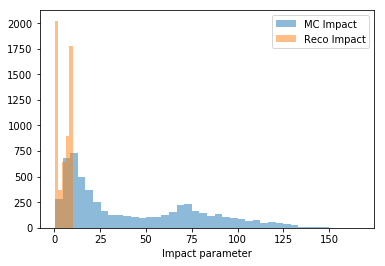

In [17]:
fig,ax = plt.subplots()
n, bins, patches = ax.hist(MCImpactP, 40, alpha=0.5, label='MC Impact')
n, bins, patches = ax.hist(ImpactParam, 5, alpha=0.5, label='Reco Impact')
ax.legend()
ax.set_xlabel('Impact parameter')
#fig.savefig(maindir+'figures/Impact.png')


Text(0,0.5,'Y distance [m]')

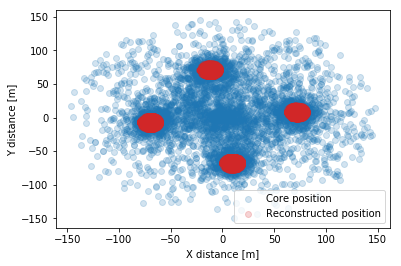

In [18]:
fig,ax = plt.subplots()
ax.scatter(Core_x, Core_y, label='Core position', alpha=0.2)
ax.scatter(Impact_arr_x, Impact_arr_y, label='Reconstructed position',color='C3', alpha=0.2)

ax.legend()
ax.set_xlabel('X distance [m]')
ax.set_ylabel('Y distance [m]')
#fig.savefig(maindir+'figures/Reco_core.png')

Text(0,0.5,'Muon Size [pe]')

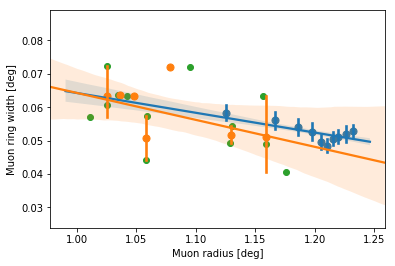

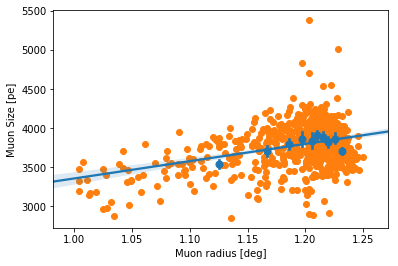

In [19]:
fig,ax = plt.subplots()
ax.scatter(RingRadius[(RingComp > 0.9) & (NTels == 1)], 
           RingWidth[(RingComp > 0.9) & (NTels == 1)], color='C2',zorder=1)
ax = sns.regplot(x=RingRadius[(RingComp > 0.9) & (NTels > 1)], y=RingWidth[(RingComp > 0.9) & (NTels > 1)], x_bins=10)
ax = sns.regplot(x=RingRadius[(RingComp > 0.9) & (NTels == 1)], y=RingWidth[(RingComp > 0.9) & (NTels == 1)], x_bins=10)

ax.set_xlabel('Muon radius [deg]')
ax.set_ylabel('Muon ring width [deg]')


fig,ax2 = plt.subplots()
ax2.scatter(RingRadius[(RingComp > 0.9)], 
           RingSize[(RingComp > 0.9)], color='C1',zorder=1)
ax2=sns.regplot(x=RingRadius[(RingComp > 0.9) & (NTels > 1)], y=RingSize[(RingComp > 0.9) & (NTels > 1)], x_bins=10)

ax2.set_xlabel('Muon radius [deg]')
ax2.set_ylabel('Muon Size [pe]')

<font size="8">__STEREO__</font>
<br>
<br>
<font size="6">PLOTS FOR DIFFERENT OPTICAL EFFICIENCIES</font>

In [20]:
def format_axes(ax,option):
    
    if(option=='width'):
        ax.set_xlabel('Muon radius [deg]')
        ax.set_ylabel('Muon ring width [deg]')
        ax.grid(linestyle="dashed")
        ax.set_ylim(0.042,0.07)
        ax.legend()
    if(option=='size'):
        ax2.grid(linestyle="dashed")
        ax2.legend(ncol=2)
        ax2.set_xlabel('Muon radius [deg]')
        ax2.set_ylabel('Muon Size [pe]')
        ax2.set_ylim(2000,4500)
        
    if(option=='eff_histo'):
        ax3.legend()
        ax3.set_xlim(0,0.02)
        ax3.set_xlabel('Muon efficiency')

    if(option=='efficiency'):
        ax4.set_xlim(50,102)
        ax4.set_ylim(0,0.02)
        ax4.set_xlabel('Optical efficiency [%]')
        ax4.set_ylabel('Muon efficiency')
        
    if(option=='reso'):
        ax5.set_xlim(50,102)
        ax5.set_ylim(0,0.002)
        ax5.set_xlabel('Optical efficiency [%]')
        ax5.set_ylabel('Resolution')


In [21]:
RingR = []
RingS = []
RingW = []
RingC = []
NT = []
MEff = []

for opt_eff in OPT_EFF:
    maindir='../../cta-lstchain-extra/muons/sample_data/Stereo/Array_centered_OptEff%.1f/' % (opt_eff)

    sfn = sorted(os.listdir(maindir + 'files')) # Sort the filename list

    RingWidth = []
    MuonEff = []
    ImpactParam = []
    RingCont = []
    RingComp = []
    RingPixComp = []
    Core_x = []
    Core_y = []
    Impact_arr_x = []
    Impact_arr_y = []
    MCImpactP = []
    ImpactDiff = []
    RingSize = []
    RingRadius = []
    NTels = []

    for filename in sfn:
        if filename.endswith(".fits"):
            table=fits.open("%s/%s" % (maindir + 'files',filename))
            data=table[1].data
        
            MuonEff = np.concatenate([MuonEff,data.field(0)])
            ImpactParam = np.concatenate([ImpactParam,data.field(1)])
            RingWidth = np.concatenate([RingWidth,data.field(2)])
            RingCont = np.concatenate([RingCont,data.field(3)])
            RingComp = np.concatenate([RingComp,data.field(4)])
            RingPixComp = np.concatenate([RingPixComp,data.field(5)])
            Core_x = np.concatenate([Core_x,data.field(6)])
            Core_y = np.concatenate([Core_y,data.field(7)])
            Impact_arr_x = np.concatenate([Impact_arr_x,data.field(8)])
            Impact_arr_y = np.concatenate([Impact_arr_y,data.field(9)])
            MCImpactP = np.concatenate([MCImpactP,data.field(10)])
            ImpactDiff = np.concatenate([ImpactDiff,data.field(11)])
            RingSize = np.concatenate([RingSize,data.field(12)])
            RingRadius = np.concatenate([RingRadius,data.field(13)])
            NTels = np.concatenate([NTels,data.field(14)])
 
    RingR.append(RingRadius)
    RingS.append(RingSize)
    RingW.append(RingWidth)
    RingC.append(RingComp)
    NT.append(NTels)
    MEff.append(MuonEff)

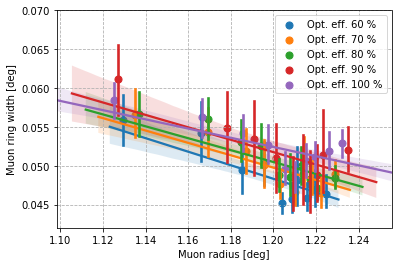

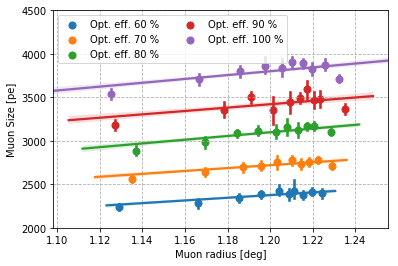

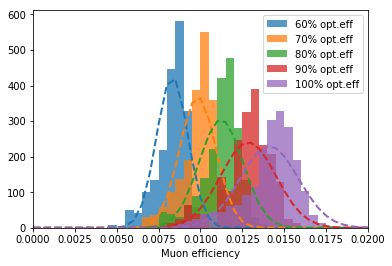

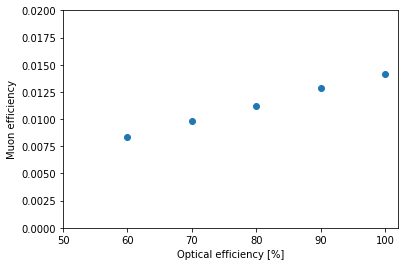

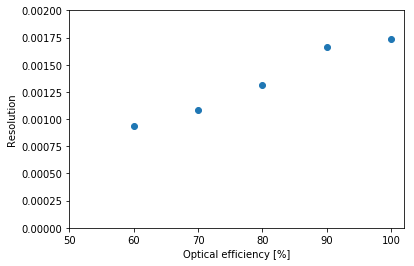

In [22]:
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
fig4,ax4 = plt.subplots()
fig5,ax5 = plt.subplots()

for (r,s,w,c,e,ntel,m,col) in zip(RingR,RingS,RingW,RingC,OPT_EFF,NT,MEff,colors):
    sns.regplot(x=r[(c > 0.9) & (ntel > 1)], y=w[(c > 0.9) & (ntel > 1)],
                     x_bins=10, label='Opt. eff. %.0f %%' %(e*100), ax=ax, color=col)

    sns.regplot(x=r[(c > 0.9) & (ntel > 1)], y=s[(c > 0.9) & (ntel > 1)], 
                    x_bins=10, label='Opt. eff. %.0f %%' %(e*100), ax=ax2, color=col)

    n, bins, patches = ax3.hist(m[(c > 0.9) & (ntel > 1)], 40, range=[0,0.02], 
                                density=1, alpha=0.75,label=("%.0f%% opt.eff" % (e*100)), color=col)
    (mu, sigma) = norm.fit(m[(c > 0.9) & (ntel > 1) & (m < 0.025)]) # Fit data         
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = ax3.plot(bins, y, 'k--', linewidth=2, color=col)

    ax4.scatter(e*100,mu,color='C0')
    ax5.scatter(e*100,sigma,color='C0')

format_axes(ax,'width')        
format_axes(ax2,'size')        
format_axes(ax3,'eff_histo')        
format_axes(ax4,'efficiency')        
format_axes(ax5,'reso')        
 

#fig.savefig(maindir+'../figures/Width_vs_radius_several_eff.png')
#fig2.savefig(maindir+'../figures/Size_vs_radius_several_eff.png')
#fig3.savefig(maindir+'../figures/Muon_eff_hist_several_eff.png')
#fig4.savefig(maindir+'../figures/Muon_eff_vs_opt_eff.png')
#fig5.savefig(maindir+'../figures/Muon_res_vs_opt_eff.png')
plt.show()

<font size="6">PLOTS FOR DIFFERENT MIRROR MISALIGNMENTS</font>

In [23]:
RingR = []
RingS = []
RingW = []
RingC = []
NT = []
MEff = []

for mir_mis in MIR_MIS:
    maindir='../../cta-lstchain-extra/muons/sample_data/Stereo/Array_centered_MirMis'+str(mir_mis)+'/'

    sfn = sorted(os.listdir(maindir + 'files')) # Sort the filename list

    RingWidth = []
    MuonEff = []
    ImpactParam = []
    RingCont = []
    RingComp = []
    RingPixComp = []
    Core_x = []
    Core_y = []
    Impact_arr_x = []
    Impact_arr_y = []
    MCImpactP = []
    ImpactDiff = []
    RingSize = []
    RingRadius = []
    NTels = []

    for filename in sfn:
        if filename.endswith(".fits"):
            table=fits.open("%s/%s" % (maindir + 'files',filename))
            data=table[1].data
        
            MuonEff = np.concatenate([MuonEff,data.field(0)])
            RingWidth = np.concatenate([RingWidth,data.field(2)])
            ImpactParam = np.concatenate([ImpactParam,data.field(1)])
            RingCont = np.concatenate([RingCont,data.field(3)])
            RingComp = np.concatenate([RingComp,data.field(4)])
            RingPixComp = np.concatenate([RingPixComp,data.field(5)])
            Core_x = np.concatenate([Core_x,data.field(6)])
            Core_y = np.concatenate([Core_y,data.field(7)])
            Impact_arr_x = np.concatenate([Impact_arr_x,data.field(8)])
            Impact_arr_y = np.concatenate([Impact_arr_y,data.field(9)])
            MCImpactP = np.concatenate([MCImpactP,data.field(10)])
            ImpactDiff = np.concatenate([ImpactDiff,data.field(11)])
            RingSize = np.concatenate([RingSize,data.field(12)])
            RingRadius = np.concatenate([RingRadius,data.field(13)])
            NTels = np.concatenate([NTels,data.field(14)])
 
    RingR.append(RingRadius)
    RingS.append(RingSize)
    RingW.append(RingWidth)
    RingC.append(RingComp)
    NT.append(NTels)
    MEff.append(MuonEff)

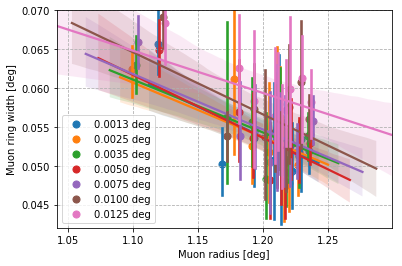

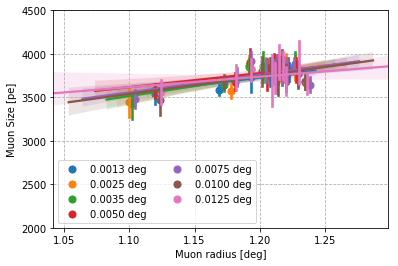

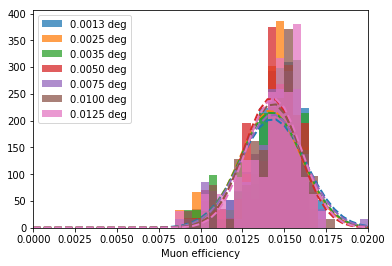

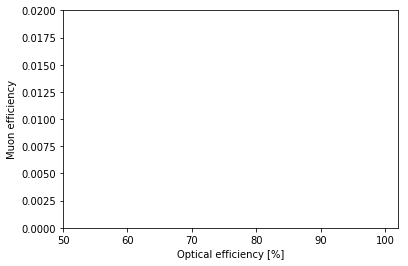

In [24]:
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
fig4,ax4 = plt.subplots()

colors2 = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
for (r,s,w,c,mis,ntel,m,col) in zip(RingR,RingS,RingW,RingC,MIR_MIS,NT,MEff,colors2):
    sns.regplot(x=r[(c > 0.9) & (ntel > 1)], y=w[(c > 0.9) & (ntel > 1)], 
                     x_bins=10, label='%.4f deg' %(mis), ax=ax, color=col)
    sns.regplot(x=r[(c > 0.9) & (ntel > 1)], y=s[(c > 0.9) & (ntel > 1)], 
                    x_bins=10, label='%.4f deg' %(mis), ax=ax2, color=col)
    
    n, bins, patches = ax3.hist(m[(c > 0.9) & (ntel > 1)], 40, range=[0,0.02], 
                                density=1, alpha=0.75,label=("%.4f deg" % (mis)), color=col)
    (mu, sigma) = scipy.stats.norm.fit(m[(c > 0.9) & (ntel > 1) & (m < 0.025)]) # Fit data         
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = ax3.plot(bins, y, 'k--', linewidth=2, color=col)

    ax4.scatter(mis,mu,color='C0')

format_axes(ax,'width')        
format_axes(ax2,'size')        
format_axes(ax3,'eff_histo')        
format_axes(ax4,'efficiency')  

#fig.savefig(maindir+'../figures/Width_vs_radius_several_mirr_mis.png')
#fig2.savefig(maindir+'../figures/Size_vs_radius_several_mirr_mis.png')
#fig3.savefig(maindir+'../figures/Muon_eff_hist_several_mirr_mis.png')
#fig4.savefig(maindir+'../figures/Muon_eff_vs_mirr_mis.png')
plt.show()

<font size="8">__SINGLE TELESCOPE__</font>
<br>
<br>
<font size="6">PLOTS FOR DIFFERENT OPTICAL EFFICIENCIES</font>

In [25]:
RingR = []
RingS = []
RingW = []
RingC = []
NT = []
MEff = []

for opt_eff in OPT_EFF:
    file='../../cta-lstchain-extra/muons/sample_data/Single_telescope/muon_0deg_0deg_run69___cta-prod3-lst_desert-2180m-LaPalma-lst-OptEff%.1f.fits' % (opt_eff)
    print(file)
    #sfn = sorted(os.listdir(maindir + 'files')) # Sort the filename list

    RingWidth = []
    MuonEff = []
    ImpactParam = []
    RingCont = []
    RingComp = []
    RingPixComp = []
    Core_x = []
    Core_y = []
    Impact_arr_x = []
    Impact_arr_y = []
    MCImpactP = []
    ImpactDiff = []
    RingSize = []
    RingRadius = []
    NTels = []

    table=fits.open("%s" % (file))
    data=table[1].data
        
    MuonEff = np.concatenate([MuonEff,data.field(0)])
    RingWidth = np.concatenate([RingWidth,data.field(2)])
    ImpactParam = np.concatenate([ImpactParam,data.field(1)])
    RingCont = np.concatenate([RingCont,data.field(3)])
    RingComp = np.concatenate([RingComp,data.field(4)])
    RingPixComp = np.concatenate([RingPixComp,data.field(5)])
    Core_x = np.concatenate([Core_x,data.field(6)])
    Core_y = np.concatenate([Core_y,data.field(7)])
    Impact_arr_x = np.concatenate([Impact_arr_x,data.field(8)])
    Impact_arr_y = np.concatenate([Impact_arr_y,data.field(9)])
    MCImpactP = np.concatenate([MCImpactP,data.field(10)])
    ImpactDiff = np.concatenate([ImpactDiff,data.field(11)])
    RingSize = np.concatenate([RingSize,data.field(12)])
    RingRadius = np.concatenate([RingRadius,data.field(13)])
    NTels = np.concatenate([NTels,data.field(14)])
 
    RingR.append(RingRadius)
    RingS.append(RingSize)
    RingW.append(RingWidth)
    RingC.append(RingComp)
    NT.append(NTels)
    MEff.append(MuonEff)

../../cta-lstchain-extra/muons/sample_data/Single_telescope/muon_0deg_0deg_run69___cta-prod3-lst_desert-2180m-LaPalma-lst-OptEff0.6.fits
../../cta-lstchain-extra/muons/sample_data/Single_telescope/muon_0deg_0deg_run69___cta-prod3-lst_desert-2180m-LaPalma-lst-OptEff0.7.fits
../../cta-lstchain-extra/muons/sample_data/Single_telescope/muon_0deg_0deg_run69___cta-prod3-lst_desert-2180m-LaPalma-lst-OptEff0.8.fits
../../cta-lstchain-extra/muons/sample_data/Single_telescope/muon_0deg_0deg_run69___cta-prod3-lst_desert-2180m-LaPalma-lst-OptEff0.9.fits
../../cta-lstchain-extra/muons/sample_data/Single_telescope/muon_0deg_0deg_run69___cta-prod3-lst_desert-2180m-LaPalma-lst-OptEff1.0.fits


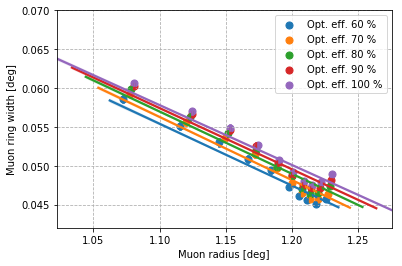

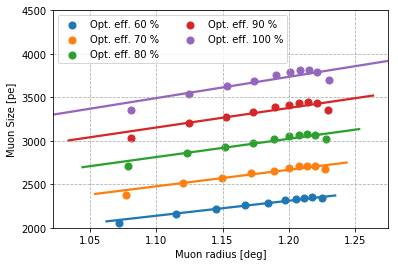

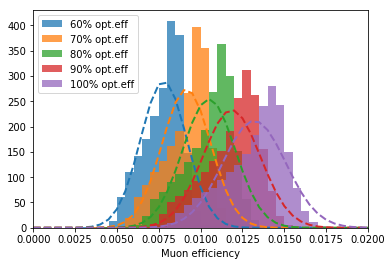

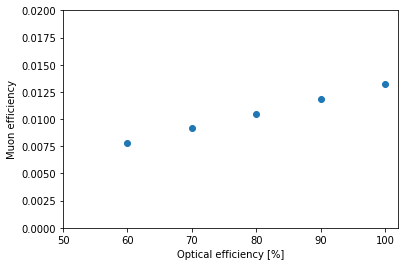

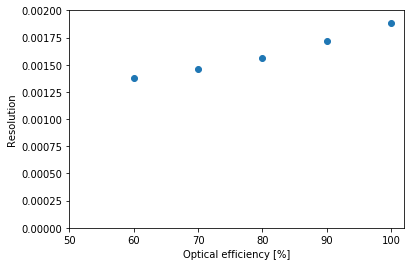

In [26]:
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
fig4,ax4 = plt.subplots()
fig5,ax5 = plt.subplots()

for (r,s,w,c,e,ntel,m,col) in zip(RingR,RingS,RingW,RingC,OPT_EFF,NT,MEff,colors):
    sns.regplot(x=r[(c > 0.9) & (ntel == 1)], y=w[(c > 0.9) & (ntel == 1)], 
                     x_bins=10, label='Opt. eff. %.0f %%' %(e*100), ax=ax, color=col)

    sns.regplot(x=r[(c > 0.9) & (ntel == 1)], y=s[(c > 0.9) & (ntel == 1)], 
                    x_bins=10, label='Opt. eff. %.0f %%' %(e*100), ax=ax2, color=col)

    n, bins, patches = ax3.hist(m[(c > 0.9) & (ntel == 1)], 40, range=[0,0.02], 
                                density=1, alpha=0.75,label=("%.0f%% opt.eff" % (e*100)), color=col)
    (mu, sigma) = scipy.stats.norm.fit(m[(c > 0.9) & (ntel == 1) & (m < 0.025)]) # Fit data         
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = ax3.plot(bins, y, 'k--', linewidth=2, color=col)

    ax4.scatter(e*100,mu,color='C0')
    ax5.scatter(e*100,sigma,color='C0')

format_axes(ax,'width')        
format_axes(ax2,'size')        
format_axes(ax3,'eff_histo')        
format_axes(ax4,'efficiency')  
format_axes(ax5,'reso')  

#fig.savefig(maindir+'../../Single_telescope/figures/Width_vs_radius_several_eff_single_tel.png')
#fig2.savefig(maindir+'../../Single_telescope/figures/Size_vs_radius_several_eff_single_tel.png')
#fig3.savefig(maindir+'../../Single_telescope/figures/Muon_eff_hist_several_eff_single_tel.png')
#fig4.savefig(maindir+'../../Single_telescope/figures/Muon_eff_vs_opt_eff_single_tel.png')
#fig5.savefig(maindir+'../../Single_telescope/figures/Muon_res_vs_opt_eff_single_tel.png')
plt.show()